# Battleship

In this lab, we are going to develop an AI to play battleship.
We will first develop some simple hard-coded strategies and we will analyse their performance.
Then we will proceed to develop a game strategy based on a probabilistic approach which seeks to maximize the *expected reward*.
This last technique is known as Thompson sampling, one of the most efficient and effective algorithms to solve the *Multi-Armed Bandit* problem.

## Rules of the game
Battleship is tipically played on a 10x10 grid. Each opponent places five ships on the board and the goal is to find and destray all the opponent's ships before the other does.
Ships can be placed only in contiguos cells of the grid, either vertically or horizontally. The five ships are as follows:
- Aircraft Carrier: 5 cells
- Battleship: 4 cells
- Submarine: 3 cells
- Cruiser: 3 cells
- Destroyer: 2 cells

Ships cannot overlap (two ships cannot occupy the same cell) and cannot extend beyond the borders of the grid!
Next to the grid on which ships are placed, each player has another 10x10 grid to keep track of fired locations, hits and misses.

Every turn, a player shots at a coordinate and the other player says if it was a hit or a miss. If one of the ships gets sunk, the player has to declare which ship was sunk after declaring the hit.

## Preliminaries
In this lab, we are going to focus on heuristics to win at battleship, so we are going to simulate a number of games by creating random dispositions of ships against which our heuristics are going to play.
Since there is no real opponent for our algorithms, we are going to measure the success of our algorithms not in terms of number of won games, but in terms of number of turns required to discover and sink all the ships.

First, let's write some support code to generate random dispositions of ships on 10x10 grids.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

output_strategy = ListedColormap(['white', '#F0E442', '#D55E00'])
ship_placement = ListedColormap(['white', '#D55E00', '#0072B2', '#CC79A7', '#009E73', '#E69F00'])

In [ ]:
def create_random_disposition():
    grid_size = 10
    grid = np.zeros((grid_size, grid_size), dtype=int)
    ships = {'Carrier': 5, 'Battleship': 4, 'Cruiser': 3, 'Submarine': 3, 'Destroyer': 2}

    def can_place_ship(x, y, length, horizontal):
        if horizontal:
            if y + length > grid_size:
                return False
            for i in range(length):
                if grid[x, y + i] != 0:
                    return False
        else:
            if x + length > grid_size:
                return False
            for i in range(length):
                if grid[x + i, y] != 0:
                    return False
        return True

    def place_ship(x, y, length, horizontal, ship_id):
        if horizontal:
            for i in range(length):
                grid[x, y + i] = ship_id
        else:
            for i in range(length):
                grid[x + i, y] = ship_id

    ship_id = 1
    for ship, length in ships.items():
        placed = False
        while not placed:
            horizontal = np.random.choice([True, False])
            if horizontal:
                x = np.random.randint(0, grid_size - 1)
                y = np.random.randint(0, grid_size - length)
            else:
                x = np.random.randint(0, grid_size - length)
                y = np.random.randint(0, grid_size - 1)

            if can_place_ship(x, y, length, horizontal):
                place_ship(x, y, length, horizontal, ship_id)
                placed = True
        ship_id += 1

    return grid

# Example usage:
random_grid = create_random_disposition()
print(random_grid)

[[0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 5 0 0 0]
 [3 0 0 1 0 4 5 0 0 0]
 [3 0 0 1 0 0 0 0 0 0]
 [3 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 2 0 0 0]
 [0 0 0 1 0 0 2 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### Generating a large collection of random games to test the different strategies
Now, we generate a collection of games against which our heuristics are going to compete. For large numbers, it might take a while.

In [ ]:
N = 10000
random_games = [create_random_disposition() for i in range(N)]

## Random Firing Strategy
This is the easiest strategy. We just fire at random, ignoring whether we hit or miss. This is not a real strategy, but confirming that we can do better than random is always the first baseline!
Write a function which plays the random attack strategy and returns in output the number of turns is takes to sink all the opponent's ships.

In [ ]:
# Function to play a random attack strategy
# Takes in input a grid with the ships locations and returns:
# 1) a matrix with the attack where each entry is as follows:
#       0: if that cell was unexplored
#       1: if that cell was a miss
#       2: if that cell was a hit
# 2) the number of turns it took to sink them.

def all_ships_sunk(grid, shot_grid):
    for row in range(len(grid)):
      for col in range(len(grid)):
        if grid[row,col] != 0 and shot_grid[row,col] == 0:
          return False
    return True

def random_attack_strategy(grid):
    turns = 0
    grid_size = len(grid)
    shot_grid = np.zeros((grid_size, grid_size), dtype=int)
    while not all_ships_sunk(grid,shot_grid):
      turns+=1
      hit = False
      rand_row = rand_col = -1
      while not hit:
        rand_row = np.random.randint(0, grid_size)
        rand_col = np.random.randint(0, grid_size)
        if shot_grid[rand_row, rand_col] == 0:
          hit = True
      if grid[rand_row, rand_col] == 0:
        shot_grid[rand_row, rand_col] = 1
      else:
        shot_grid[rand_row, rand_col] = 2
    return shot_grid, turns


### Visualizing the performance of random firing strategy

Number of turns taken to sink all ships: 95


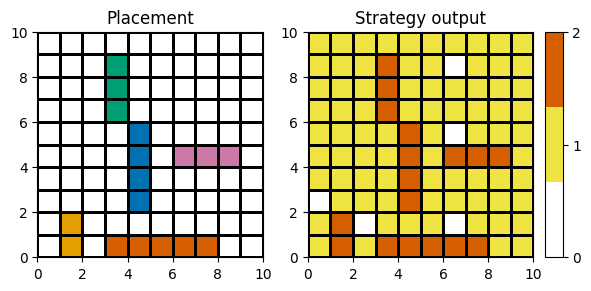

In [ ]:
# Example for random firing strategy
rand_disp = create_random_disposition()
shot_grid, turns_taken = random_attack_strategy(rand_disp)
fig, axs = plt.subplots(1,2)
pcm = axs[0].pcolormesh(rand_disp, cmap=ship_placement, edgecolors='k')
axs[0].set_aspect("equal")
axs[0].set_title("Placement")
pcm = axs[1].pcolormesh(shot_grid, cmap=output_strategy, edgecolors='k', vmin = 0, vmax=2)
axs[1].set_aspect("equal")
axs[1].set_title("Strategy output")
cax = axs[1].inset_axes((1.05, 0, 0.08, 1.0))
fig.colorbar(pcm, cax=cax, ticks = [0, 1, 2])
print(f"Number of turns taken to sink all ships: {turns_taken}")

In [ ]:
random_n_turns = [random_attack_strategy(game)[1] for game in random_games]

Text(0.5, 1.0, 'Histogram for Random Strategy')

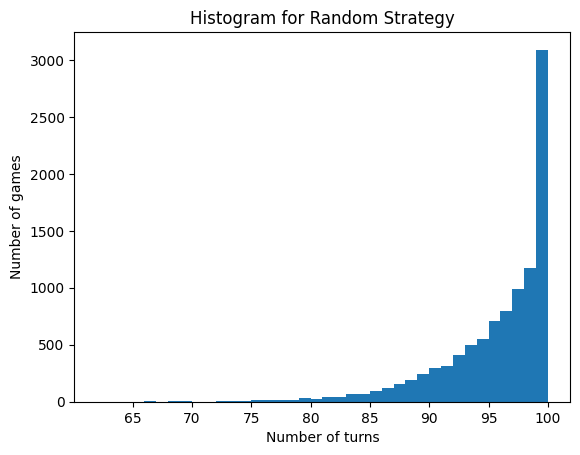

In [ ]:
n_bins = max(set(random_n_turns)) - min(set(random_n_turns))
plt.hist(random_n_turns, bins = n_bins)
plt.xlabel("Number of turns")
plt.ylabel("Number of games")
plt.title("Histogram for Random Strategy")

## The "Hunt and Target" strategy
Obviously, the random strategy performs quite poorly. This is so because the random strategy considers each location as equally probable and ignores when a ship has been hit.
We can do much better with a strategy named "hunt and target". The idea behind this strategy is slightly more complicated than the random strategy.
We beging with a random search and, once we hit a boat, we target the area surrounding that hit until we sink that boat. Once the boat has been sinked, we resume a random search pattern.
This strategy tries to strike a balance between exploration and exploitation.

Implementing this idea, in its most basic form, is quite easy: each time we hit a ship, we switch to a **target** mode by firing in one of the four cells neighbouring the cell in which we hit our opponent.
Of course, we consider these cells only if they have not already been considered (i.e. only if we did not hit or miss already in one of these cells).
When we have considered all the neighbouring cell, we can switch back to the **hunt** mode.

Also, we can restrict the space of random shooting when in hunt mode: no need to shoot at every location, since the smallest ship in the game occupies two cells.
We can just shoot randomly in a checkerboard pattern.

Now, you can implement the "hunt and target" strategy!

In [ ]:
def int2pair(value,grid_len):
  return (value//grid_len, value%grid_len)

def get_checkerboard_cells(grid_len):
  cell_number = 1
  checkerboard_cells = []
  while cell_number < grid_len*grid_len:
    checkerboard_cells.append(cell_number)
    if cell_number%grid_len == grid_len-1:
      cell_number += 1
    elif cell_number%grid_len == grid_len-2:
      cell_number += 3
    else:
      cell_number += 2
  return checkerboard_cells

def get_neighborhood_attacks(row,col,shot_grid):
  next_attacks = [(row-1,col), (row+1,col), (row,col-1), (row,col+1)]
  for cell in next_attacks:
    if (cell[0]<0 or cell[0]>=len(shot_grid) or cell[1]<0 or cell[1]>=len(shot_grid)) or (shot_grid[cell[0],cell[1]] != 0):
      next_attacks.remove(cell)
  return next_attacks


def hunt_and_target_strategy(grid):
    turns = 0
    grid_size = (len(grid),len(grid))
    shot_grid = np.zeros(grid_size, dtype=int)

    while not all_ships_sunk(grid,shot_grid):
      hunt_mode = True
      checkerboard_cells = get_checkerboard_cells(len(grid))

      while hunt_mode:
        cell_number = np.random.randint(grid_size[0]*grid_size[1])
        while not cell_number in checkerboard_cells:
          cell_number = np.random.randint(grid_size[0]*grid_size[1])
        next_pair = int2pair(cell_number,grid_size[0])
        if shot_grid[next_pair[0],next_pair[1]] == 0:
          if grid[next_pair[0],next_pair[1]] != 0:
            hunt_mode = False
            shot_grid[next_pair[0],next_pair[1]] = 2
          else:
            shot_grid[next_pair[0],next_pair[1]] = 1
          turns+=1

      next_attacks = get_neighborhood_attacks(next_pair[0],next_pair[1], shot_grid)
      while len(next_attacks) > 0:
        next_attack = next_attacks.pop()
        next_row, next_col = next_attack[0], next_attack[1]
        if grid[next_row,next_col] != 0:
          shot_grid[next_row,next_col] = 2
        else:
          shot_grid[next_row,next_col] = 1
        turns+=1
    return (shot_grid, turns)

### Visualizing the performance of the "Hunt and Target" strategy

Number of turns taken to sink all ships: 74


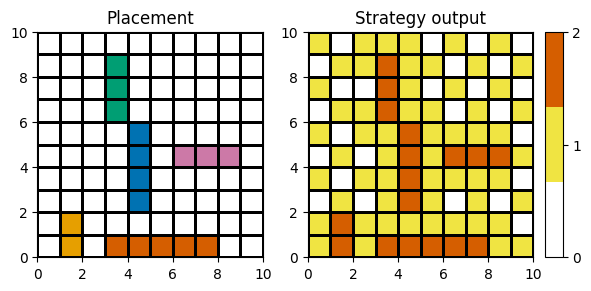

In [ ]:
# Example for random firing strategy
# rand_disp = create_random_disposition()
shot_grid, turns_taken = hunt_and_target_strategy(rand_disp)
fig, axs = plt.subplots(1,2)
pcm = axs[0].pcolormesh(rand_disp, cmap=ship_placement, edgecolors='k')
axs[0].set_aspect("equal")
axs[0].set_title("Placement")
pcm = axs[1].pcolormesh(shot_grid, cmap=output_strategy, edgecolors='k', vmin = 0, vmax=2)
axs[1].set_aspect("equal")
axs[1].set_title("Strategy output")
cax = axs[1].inset_axes((1.05, 0, 0.08, 1.0))
fig.colorbar(pcm, cax=cax, ticks = [0, 1, 2])
print(f"Number of turns taken to sink all ships: {turns_taken}")

In [ ]:
hunt_and_target_n_turns = [hunt_and_target_strategy(game)[1] for game in random_games]

Text(0.5, 1.0, 'Histogram for Hunt and Target Strategy')

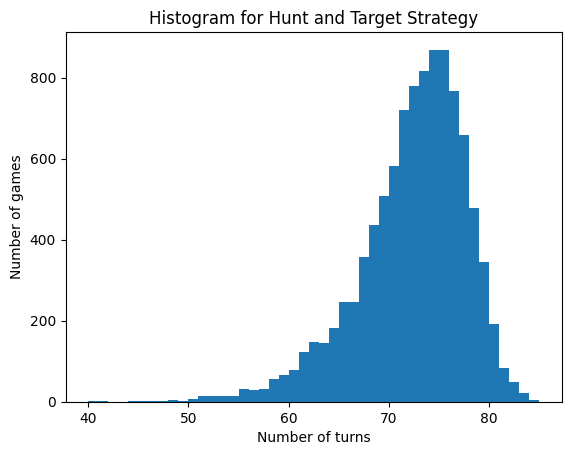

In [ ]:
n_bins = max(set(hunt_and_target_n_turns)) - min(set(hunt_and_target_n_turns))
plt.hist(hunt_and_target_n_turns, bins = n_bins)
plt.xlabel("Number of turns")
plt.ylabel("Number of games")
plt.title("Histogram for Hunt and Target Strategy")

## An adaptive strategy based on probability and utility maximization (a.k.a Thompson Sampling)

In [ ]:
# shot_grid legend
#   0 -> unexplored
#   1 -> miss
#   2 -> previously hit
#   3 -> last hit (just one cell per turn in the entire matrix)

'''
  grid_slice is the slice of the matrix that we want to process (i.e., an array)
  ship_size is, indeed, the size of the ship that we are superimposing
  starting_cell is either the cell that was processed in hunt, or the hit cell in target
  orientation is either "hor" or "ver"
'''
def process_grid_slice(shot_grid_slice, posterior_map_slice, ship_size):
    if 1 not in shot_grid_slice:    # if no misses in the slice (i.e., the ship can't be in that slice)
        for i in range(ship_size):
          if shot_grid_slice[i] == 0:
            posterior_map_slice[i] += 1

def update_posterior(shot_map, sizes, mode="hunt"):
    grid_sizes = (len(shot_map), len(shot_map[0]))
    rows = grid_sizes[0]
    cols = grid_sizes[1]

    posterior_map = np.zeros((rows,cols), dtype=int)

    for ship_size in sizes:
      if mode == "hunt":
        for i in range(rows):
          for j in range(cols):
            if j+ship_size <= cols:               # <= because slicing excludes last index
              shot_grid_slice = shot_map[i, j:j+ship_size]
              posterior_map_slice = posterior_map[i, j:j+ship_size]
              process_grid_slice(shot_grid_slice, posterior_map_slice, ship_size)

            if i+ship_size <= rows:               # <= because slicing excludes last index
              shot_grid_slice = shot_map[i:i+ship_size,j]
              posterior_map_slice = posterior_map[i:i+ship_size, j]
              process_grid_slice(shot_grid_slice, posterior_map_slice, ship_size)

      elif mode == "target":
        hit_cell = np.where(shot_map==3)
        i = hit_cell[0][0]
        j = hit_cell[1][0]

        for offset in range (0, ship_size):
          starting_row = i-offset
          if starting_row >= 0 and starting_row+ship_size <= rows:
            shot_grid_slice = shot_map[starting_row:starting_row+ship_size, j]
            posterior_map_slice = posterior_map[starting_row:starting_row+ship_size, j]
            process_grid_slice(shot_grid_slice, posterior_map_slice, ship_size)

          starting_col = int(j-offset)
          if starting_col >= 0 and starting_col+ship_size <= cols:
            shot_grid_slice = shot_map[i, starting_col:starting_col+ship_size]
            posterior_map_slice = posterior_map[i, starting_col:starting_col+ship_size]
            process_grid_slice(shot_grid_slice, posterior_map_slice, ship_size)

    return posterior_map

def get_not_sunk_ships(all_ships, grid, shot_map):
    sunk_ships = []
    hit_indexes = np.argwhere((shot_map==2)|(shot_map==3))
    for length in range(1,6):
      ship_indexes = np.argwhere(grid==length)

      every_ship_cell_is_hit = True

      for index in ship_indexes:
        if not np.any(np.all(hit_indexes == index, axis=1)):  # Confronto element-wise
          every_ship_cell_is_hit = False
          break

      if every_ship_cell_is_hit:
        sunk_ships.append(all_ships[len(all_ships)-length])

    not_sunk_ships = all_ships.copy()
    if len(sunk_ships) > 0:
      for ship in all_ships:
        if ship in sunk_ships:
          not_sunk_ships.remove(ship)
          sunk_ships.remove(ship)

    return not_sunk_ships

def get_best_coordinates(posterior_map):
    # Return the coordinates associated with the most likely location in the posterior map
    x,y = np.unravel_index(np.argmax(posterior_map), posterior_map.shape)
    return (x, y)

def thompson_sampling_strategy(grid):
    turns = 0
    all_ships = [2,3,3,4,5]
    not_sunk_ships = all_ships.copy()
    not_sunk_ships_length = len(not_sunk_ships)

    mode = "hunt"

    shot_grid = np.zeros((len(grid),len(grid[0])), dtype=int)

    while len(not_sunk_ships) > 0:
      posterior_map = update_posterior(shot_grid, not_sunk_ships, mode)
      if mode != "target":
        shot_grid[shot_grid == 3] = 2
      x, y = get_best_coordinates(posterior_map)
      if grid[x,y] == 0:   # i.e., missed
        shot_grid[x,y] = 1
      else:
        shot_grid[shot_grid == 3] = 2
        shot_grid[x,y] = 3
        mode = "target"
      not_sunk_ships = get_not_sunk_ships(all_ships.copy(), grid, shot_grid)
      if not_sunk_ships_length != len(not_sunk_ships):
        not_sunk_ships_length = len(not_sunk_ships)
        mode = "hunt"
      turns += 1

    return (shot_grid, turns)

Number of turns taken to sink all ships: 34


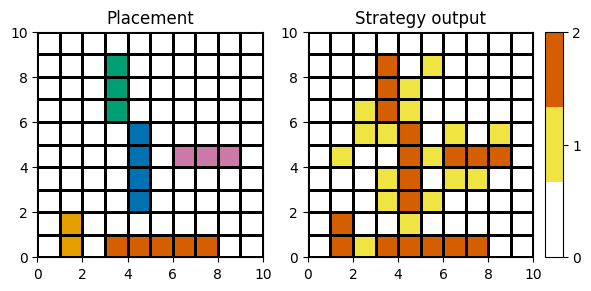

In [ ]:
# Example for random firing strategy
shot_grid, turns_taken = thompson_sampling_strategy(rand_disp)
fig, axs = plt.subplots(1,2)
pcm = axs[0].pcolormesh(rand_disp, cmap=ship_placement, edgecolors='k')
axs[0].set_aspect("equal")
axs[0].set_title("Placement")
pcm = axs[1].pcolormesh(shot_grid, cmap=output_strategy, edgecolors='k', vmin = 0, vmax=2)
axs[1].set_aspect("equal")
axs[1].set_title("Strategy output")
cax = axs[1].inset_axes((1.05, 0, 0.08, 1.0))
fig.colorbar(pcm, cax=cax, ticks = [0, 1, 2])
print(f"Number of turns taken to sink all ships: {turns_taken}")

In [ ]:
import multiprocessing
from tqdm import tqdm

def run_thompson_sampling_strategy(game):
	return thompson_sampling_strategy(game)[1]

with multiprocessing.Pool(8) as pool:
	thompson_sampling_n_turns = list(tqdm(pool.imap(run_thompson_sampling_strategy, random_games), total=len(random_games)))

100%|██████████| 10000/10000 [14:11<00:00, 11.74it/s]


Text(0.5, 1.0, 'Histogram for Thompson Sampling Strategy')

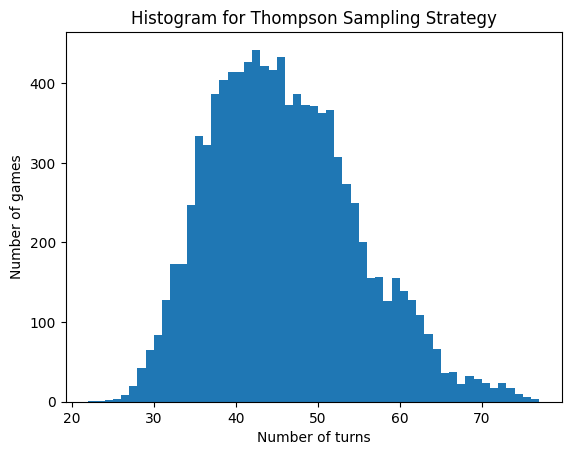

In [ ]:
n_bins = max(set(thompson_sampling_n_turns)) - min(set(thompson_sampling_n_turns))
plt.hist(thompson_sampling_n_turns, bins = n_bins)
plt.xlabel("Number of turns")
plt.ylabel("Number of games")
plt.title("Histogram for Thompson Sampling Strategy")